<a href="https://colab.research.google.com/github/abrham17/state_space_model/blob/main/ssm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install kagglehub
!pip install kaggle

In [37]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


**Downloading kagglehub dataset, preprocessing and Normalizing**



In [40]:
import kagglehub

path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

train_df = pd.read_csv(os.path.join(path, "DailyDelhiClimateTrain.csv")).dropna()
test_df = pd.read_csv(os.path.join(path, "DailyDelhiClimateTest.csv")).dropna()
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
target = 'meantemp'

scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])


**Preparing a sequence data for LSTM and SSM training**


For 25 days input it will output the next day. SO one input sequence consists of 25 days of data.and the output will contain the data of the day found after the 25 days sequence.

In [41]:
def create_sequences(data, input_len=30, pred_len=1):
    X, y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+pred_len])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_df[features].values, 30, 1)
X_test, y_test = create_sequences(test_df[features].values, 30, 1)

y_train = y_train[:, 0, 0].reshape(-1, 1)
y_test = y_test[:, 0, 0].reshape(-1, 1)


**preparing custom dataset**


In [42]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=64, shuffle=True)
test_dataset = TimeSeriesDataset(X_test, y_test)


**simple LSTM model**

In [43]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


**State space model**

In [44]:
class SimpleSSM(nn.Module):
    def __init__(self, input_dim=4, state_dim=64):
        super().__init__()
        self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.01)
        self.B = nn.Parameter(torch.randn(state_dim, input_dim) * 0.01)
        self.C = nn.Parameter(torch.randn(1, state_dim) * 0.01)

    def forward(self, x):
        Bx = torch.einsum('btd,sd->bts', x, self.B)
        h = torch.zeros((x.size(0), self.A.size(0)), device=x.device)
        for t in range(x.size(1)):
            h = h @ self.A + Bx[:, t, :]
        return h @ self.C.t()


**Training function for both the LSTM and SSM**

In [45]:
def train_model(model, dataloader, epochs=20, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss={epoch_loss / len(dataloader):.4f}")


**Evaluation function**

In [46]:
def evaluate_model(model, dataset, y_true_np):
    model.eval()
    with torch.no_grad():
        X_tensor = dataset.X
        preds = model(X_tensor).squeeze().cpu().numpy()

    y_true = y_true_np.squeeze()
    rmse = np.sqrt(((preds - y_true)**2).mean())
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)

    print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(preds[:100], label='Predicted')
    plt.plot(y_true[:100], label='True')
    plt.legend()
    plt.title("Temperature Forecast")
    plt.show()


Epoch 1: Loss=0.7170
Epoch 2: Loss=0.1865
Epoch 3: Loss=0.1003
Epoch 4: Loss=0.0873
Epoch 5: Loss=0.0778
Epoch 6: Loss=0.0728
Epoch 7: Loss=0.0716
Epoch 8: Loss=0.0691
Epoch 9: Loss=0.0648
Epoch 10: Loss=0.0643
Epoch 11: Loss=0.0623
Epoch 12: Loss=0.0605
Epoch 13: Loss=0.0598
Epoch 14: Loss=0.0590
Epoch 15: Loss=0.0568
Epoch 16: Loss=0.0567
Epoch 17: Loss=0.0566
Epoch 18: Loss=0.0566
Epoch 19: Loss=0.0539
Epoch 20: Loss=0.0535

LSTM Evaluation:
RMSE: 0.275, MAE: 0.224, R²: 0.881


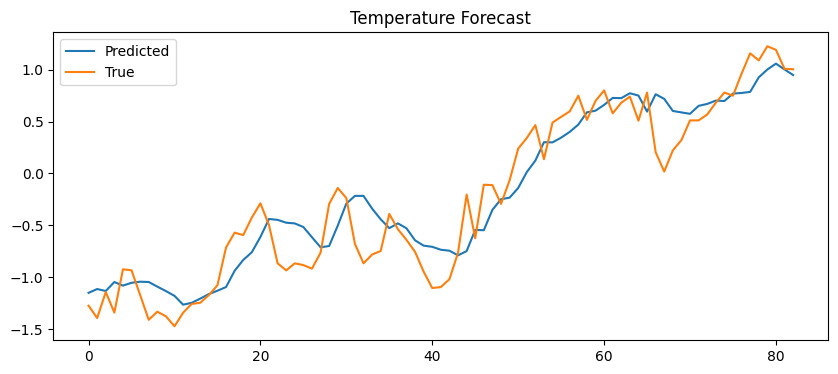

In [47]:
lstm = LSTMModel()
train_model(lstm, train_loader)
print("\nLSTM Evaluation:")
evaluate_model(lstm, test_dataset, y_test)


Epoch 1: Loss=0.7407
Epoch 2: Loss=0.2389
Epoch 3: Loss=0.1250
Epoch 4: Loss=0.0927
Epoch 5: Loss=0.0867
Epoch 6: Loss=0.0834
Epoch 7: Loss=0.0810
Epoch 8: Loss=0.0823
Epoch 9: Loss=0.0774
Epoch 10: Loss=0.0745
Epoch 11: Loss=0.0717
Epoch 12: Loss=0.0752
Epoch 13: Loss=0.0702
Epoch 14: Loss=0.0662
Epoch 15: Loss=0.0634
Epoch 16: Loss=0.0620
Epoch 17: Loss=0.0592
Epoch 18: Loss=0.0579
Epoch 19: Loss=0.0572
Epoch 20: Loss=0.0555

SSM Evaluation:
RMSE: 0.268, MAE: 0.224, R²: 0.887


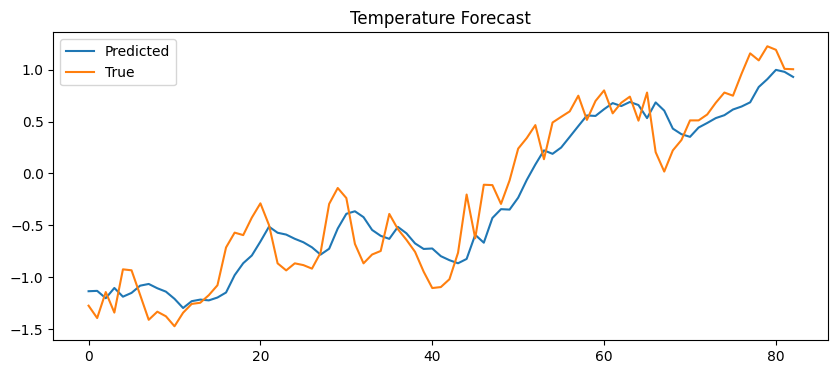

In [48]:
ssm = SimpleSSM()
train_model(ssm, train_loader)
print("\nSSM Evaluation:")
evaluate_model(ssm, test_dataset, y_test)
